In [72]:
from __future__ import print_function
from __future__ import division

import pandas as pd
import numpy as np
from fbprophet import Prophet

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style({'axes.axisbelow': True,
 'axes.edgecolor': '.8',
 'axes.facecolor': 'white',
 'axes.grid': True,
 'axes.labelcolor': '.15',
 'axes.spines.bottom': True,
 'axes.spines.left': True,
 'axes.spines.right': True,
 'axes.spines.top': True,
 'figure.facecolor': 'white',
 'font.family': ['sans-serif'],
 'font.sans-serif': ['Arial',
  'DejaVu Sans',
  'Liberation Sans',
  'Bitstream Vera Sans',
  'sans-serif'],
 'grid.color': '.9',
 'grid.linestyle': '-',
 'image.cmap': 'rocket',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': '.15',
 'xtick.bottom': False,
 'xtick.color': '.15',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': '.15',
 'ytick.direction': 'out',
 'ytick.left': False,
 'ytick.right': False})


from sklearn.model_selection import train_test_split
import statsmodels.api as sm

from statsmodels.tools import eval_measures
import statsmodels.formula.api as smf

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

%matplotlib inline
plt.rcParams['figure.figsize']= (10,4)

from warnings import filterwarnings
filterwarnings('ignore')
import datetime

## Load Data

In [73]:
train_features = pd.read_csv('./data/dengue_features_train.csv')

train_labels = pd.read_csv('./data/dengue_labels_train.csv')
train_labels = train_labels.total_cases

test_features = pd.read_csv('./data/dengue_features_test.csv')

submission = pd.read_csv('./data/submission_format.csv')

## Split Data and Preprocessing 

In [96]:
train_set = pd.concat([train_labels, train_features], axis=1)

#Renaming columns to how fbprophet requires them
train_set = train_set.rename(columns = {'week_start_date':'ds', 'total_cases':'y'})

#Coverting the string date to a datetime object
train_set['ds'] = pd.to_datetime(train_set.ds)

#Spliting the training data by city 
train_sj = train_set[train_set.city == 'sj'].copy()
train_iq = train_set[train_set.city == 'iq'].copy()

ytrain_sj = train_sj['y'].copy()
ytrain_iq = train_iq['y'].copy()

#Getting the testing data set
test_features = test_features.rename(columns = {'week_start_date':'ds'})
test_sj = test_features[test_features.city == 'sj'].copy()
test_iq = test_features[test_features.city == 'iq'].copy()


#Fill in missing values
train_sj.fillna(method='ffill', inplace=True)
test_sj.fillna(method='ffill', inplace=True)

#Splitting data for testing and training
XPtr_sj, XPts_sj, YPtr_sj, YPts_sj = train_test_split(train_sj, ytrain_sj, test_size=0.2)
XPtr_iq, XPts_iq, YPtr_iq, YPts_iq = train_test_split(train_iq, ytrain_iq, test_size=0.2)

## Util function defs

In [75]:
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
def mae_calc(test, predicted):
    return (np.abs(test - predicted).sum())/len(test)


## Training data set 

In [76]:
#Checking stationarity
adf_test(XPtr_sj.y)
adf_test(XPtr_iq.y)

Results of Dickey-Fuller Test:
Test Statistic                 -28.429691
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    747.000000
Critical Value (1%)             -3.439134
Critical Value (5%)             -2.865417
Critical Value (10%)            -2.568834
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -6.878960e+00
p-value                        1.449971e-09
#Lags Used                     9.000000e+00
Number of Observations Used    4.060000e+02
Critical Value (1%)           -3.446560e+00
Critical Value (5%)           -2.868685e+00
Critical Value (10%)          -2.570576e+00
dtype: float64


In [157]:
#Creating models
m_sj = Prophet(changepoint_prior_scale = 1, yearly_seasonality= 52)
m_sj.fit(XPtr_sj);

m_iq = Prophet(changepoint_prior_scale = 1, yearly_seasonality= 52)
m_iq.fit(XPtr_iq);

#Predicting
forecast_sj = m_sj.predict(XPts_sj)
forecast_iq = m_iq.predict(XPts_iq)



INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


## Training plots

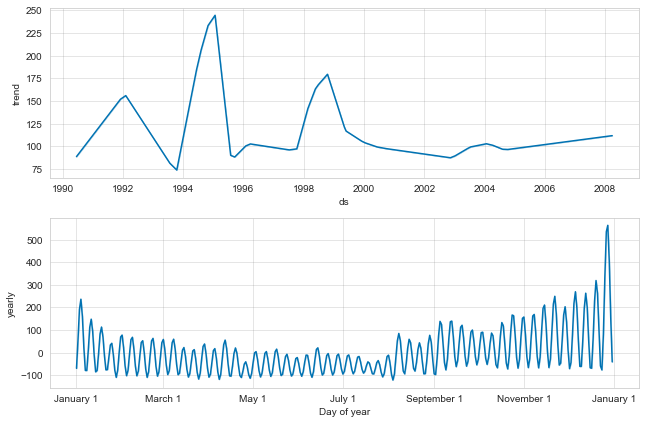

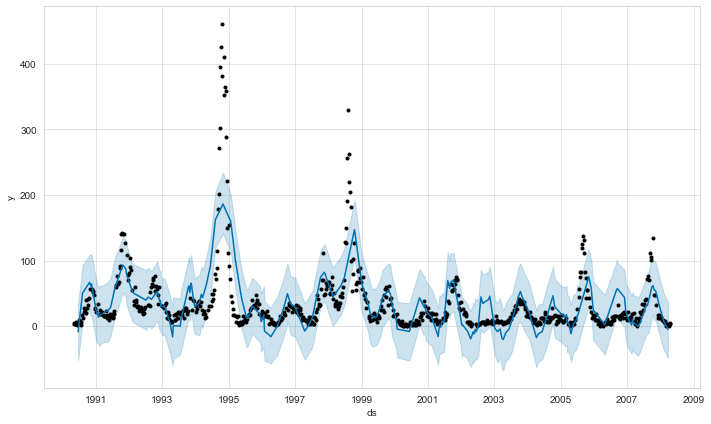

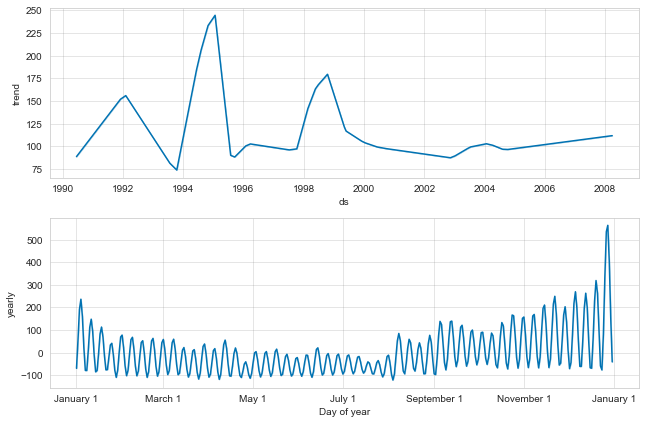

In [158]:
m_sj.plot(forecast_sj)
m_sj.plot_components(forecast_sj)


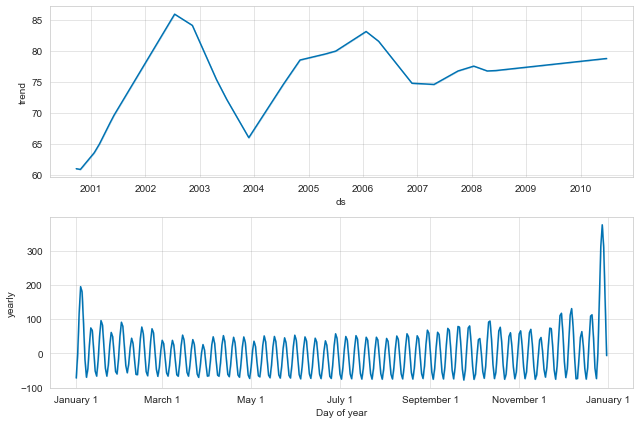

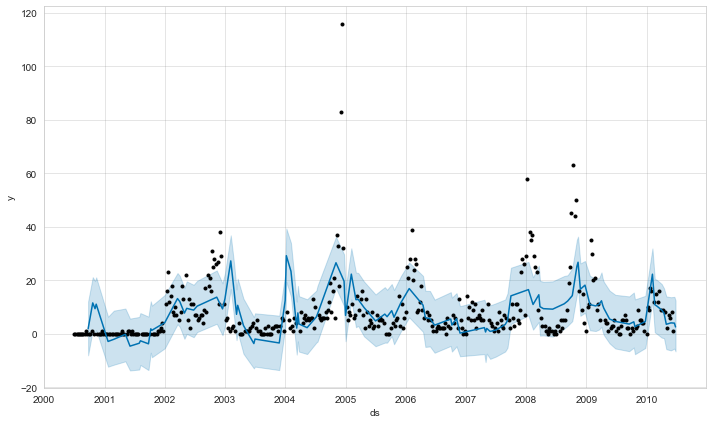

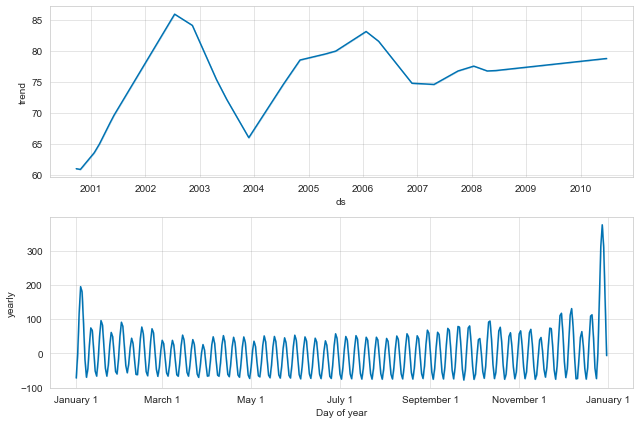

In [159]:
m_iq.plot(forecast_iq)
m_iq.plot_components(forecast_iq)


## Checking Training Results

In [124]:
# lower bounding predictions
forecast_sj['yhat'] = forecast_sj.yhat.astype(int)
forecast_sj.yhat.loc[predicts_sj < 0] = 0

predicts_iq = forecast_iq.yhat.astype(int)
predicts_iq.loc[predicts_iq < 0] = 0

#mae_calc()
print('San Juan error:', mae_calc(YPts_sj, predicts_sj))

print('Iquitos error:', mae_calc(YPts_iq, predicts_iq))

San Juan error: 4.930851063829787
Iquitos error: 0.0


## Training model on test data

In [81]:
#creating models
m2_sj = Prophet(changepoint_prior_scale=1,yearly_seasonality=52)
m2_sj.fit(train_sj);

m2_iq = Prophet(changepoint_prior_scale=1,yearly_seasonality=52)
m2_iq.fit(train_iq);


forecast2_sj = m2_sj.predict(test_sj)
forecast2_iq = m2_iq.predict(test_iq)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


## Plotting testing 

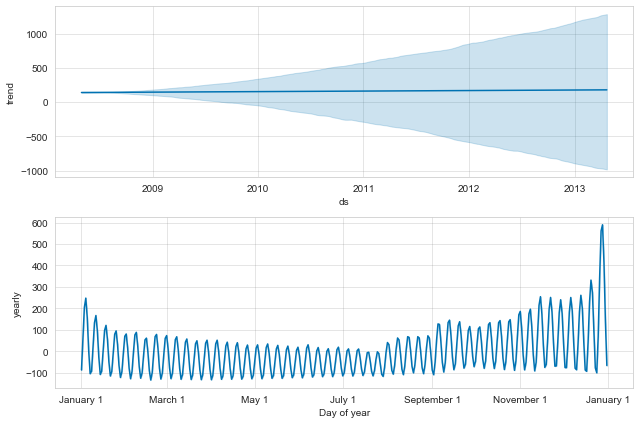

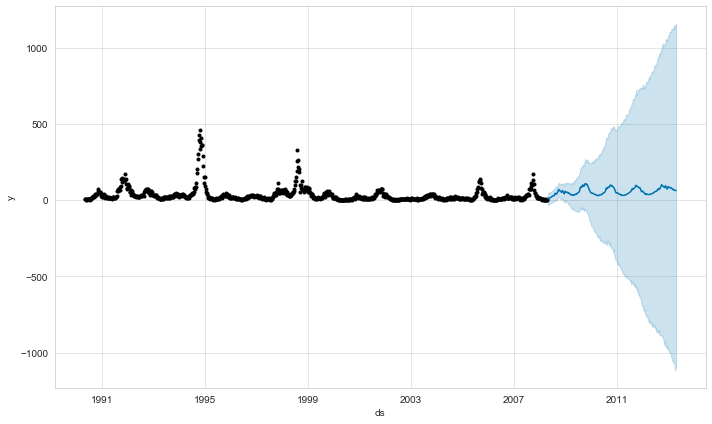

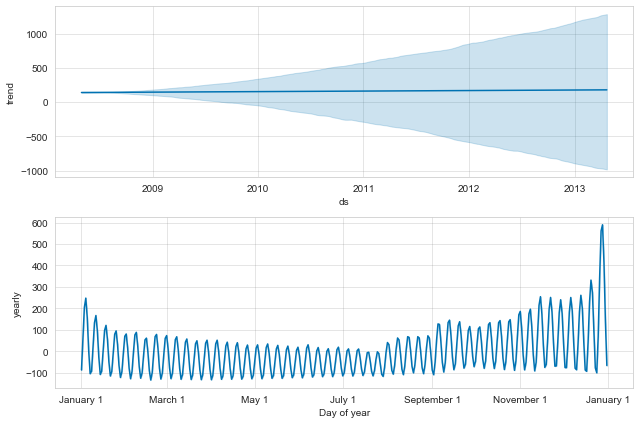

In [82]:
m2_sj.plot(forecast2_sj)
m2_sj.plot_components(forecast2_sj)

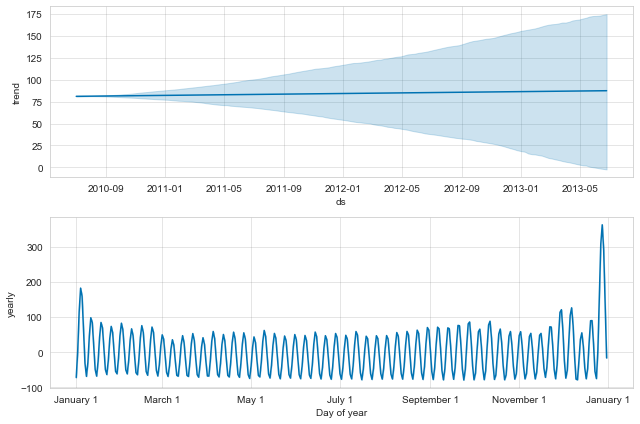

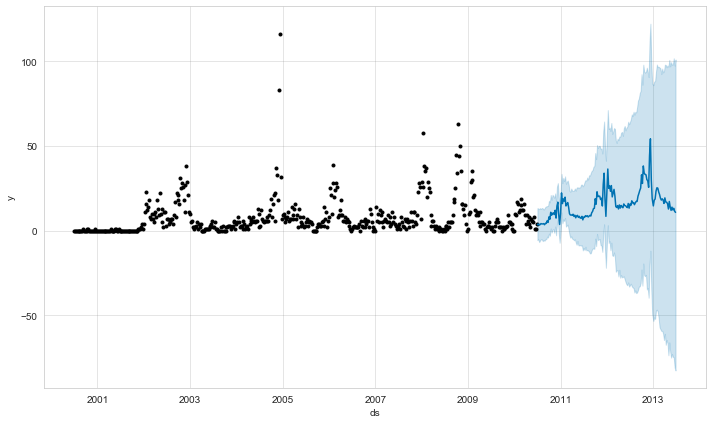

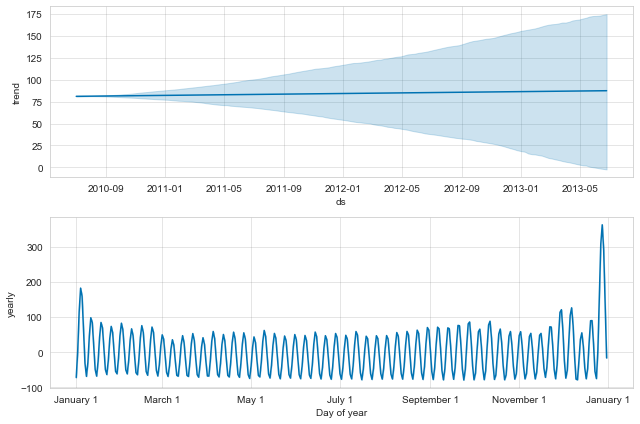

In [83]:
m2_iq.plot(forecast2_iq)
m2_iq.plot_components(forecast2_iq)

# Prep for submission

In [71]:
# Lower bounding predictions
pred2_sj = forecast2_sj[['yhat','ds']]
pred2_sj.yhat = pred2_sj.yhat.astype(int)
pred2_sj.loc[pred2_sj.yhat < 0] = 0

#prepping dataframe for submission 
pred2_sj['city'] = 'sj'
pred2_sj = pred2_sj.rename(columns = {'yhat': 'total_cases'})
pred2_sj['year'] = pred2_sj.ds.apply(lambda x: x.year)
pred2_sj['weekofyear'] = pred2_sj.ds.apply(lambda x: x.weekofyear)
pred2_sj = pred2_sj.drop(['ds'], 1)
pred2_sj = pred2_sj[['city', 'year', 'weekofyear','total_cases']]

#output results
pred2_sj.to_csv('benchmark2.csv', index=False)